## Table of Contents

- [1. Data Extraction](#1)
- [2. Exploratory Data Analysis](#2)
- [3. Model Training](#3)
- [4. Prepare the Script to Run on the GPU Platform](#4)
    - [4.1 Output](#4_1)
- [Conclusion](#end)

### 1. Data Extraction <a class="anchor" id="1"></a>

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

labels = pd.read_csv('/datasets/faces/labels.csv')
directory = '/datasets/faces/final_files/'

datagen = ImageDataGenerator(
    rescale=1./255
)

train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


### 2. Exploratory Data Analysis <a class="anchor" id="2"></a>

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# no nulls so we check duplicates
labels.drop_duplicates(inplace=True)
labels.count()

file_name    7591
real_age     7591
dtype: int64

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Text(0.5, 0, 'Age')

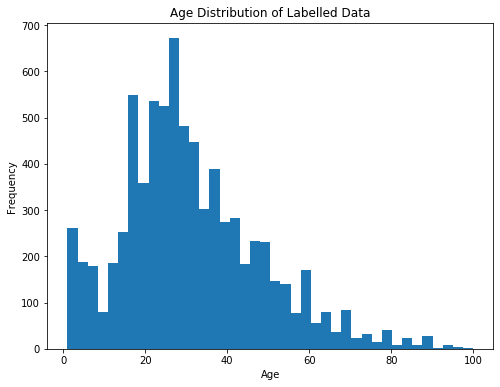

In [5]:
# look at age distribution
display(labels.describe())
ax = labels['real_age'].plot(kind='hist',bins=40,figsize=(8,6),title='Age Distribution of Labelled Data')
ax.set_xlabel('Age')

We have a good distribution largely focused on ages that make alcohol purchases.

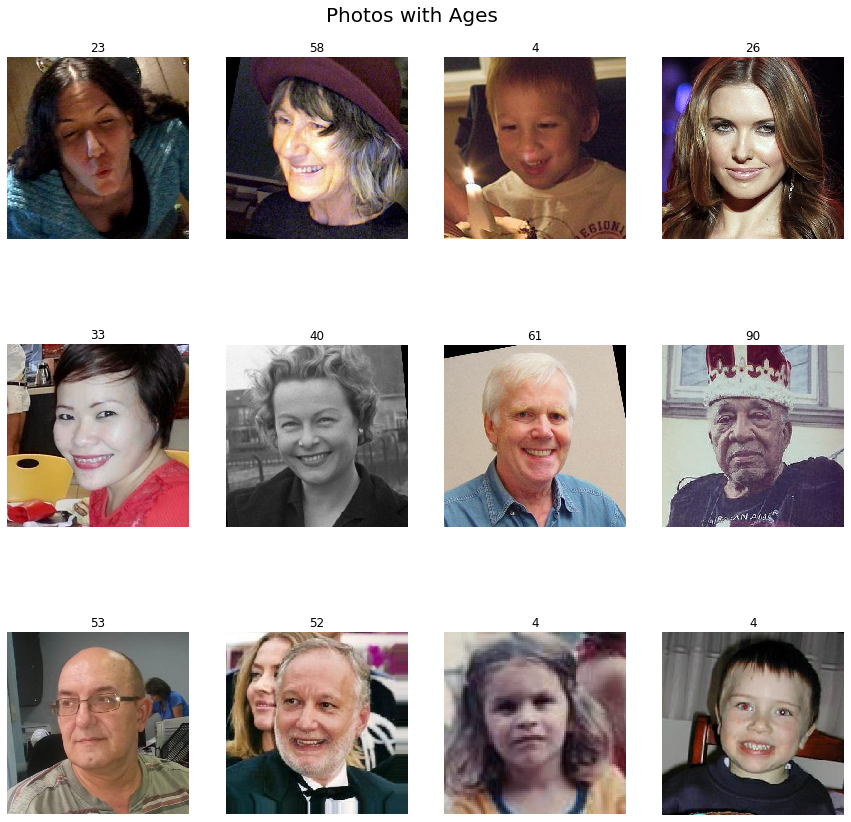

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# look at sample of data (images and ages)
directory='/datasets/faces/final_files/'
fig, axes = plt.subplots(3, 4, figsize = (15,15))
fig.suptitle('Photos with Ages',fontsize=20,y=0.9)
for row in axes:
    for axe in row:
        index = np.random.randint(len(labels))
        img = plt.imread(directory + labels['file_name'][index]) 
        age = labels['real_age'][index]
        axe.imshow(img)
        axe.set_title(age)
        axe.set_axis_off()

The data had no nulls or duplicates. The images are, a range colours and qualities, of people of various ages and genders in different facial orientations. This variety and bredth of data will help the model perform accurately.

### 3. Model Training <a class="anchor" id="3"></a>

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [7]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [8]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    
    train_gen_flow = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    ).flow_from_dataframe(
        dataframe = labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345
    ) 

    return train_gen_flow

In [9]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    
    test_gen_flow = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    ).flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345
    ) 

    return test_gen_flow

In [10]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0003)
    
    model.compile(
        loss='mae', 
        optimizer=optimizer, 
        metrics=['mae']
    )

    return model

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=100,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    # will set to 100 epochs but early stopping will prevent it running for entire 100 epochs
    earlystop = tf.keras.callbacks.EarlyStopping(patience=5)
     
    # learning rate will adjust during training
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='mae', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        callbacks=[earlystop, learning_rate_reduction]
    ) 

    return model

### 4. Prepare the Script to Run on the GPU Platform <a class="anchor" id="4"></a>

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

#### 4.1 Output <a class="anchor" id="4_1"></a>

Output from the GPU platform:

In [ ]:
2022-01-09 22:26:23.622721: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-01-09 22:26:23.986625: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-01-09 22:26:36.527724: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-09 22:26:37.159507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-09 22:26:37.159595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-09 22:26:37.159627: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-09 22:26:37.457262: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-09 22:26:37.579377: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-01-09 22:26:38.224951: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-01-09 22:26:38.314303: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-01-09 22:26:38.314470: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-01-09 22:26:38.319927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-01-09 22:26:38.320457: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-01-09 22:26:38.472618: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-01-09 22:26:38.479171: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5a3ef40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-09 22:26:38.479202: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-09 22:26:38.873271: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5ac4f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-01-09 22:26:38.873314: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-01-09 22:26:38.875791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-09 22:26:38.875851: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-09 22:26:38.875861: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-09 22:26:38.875889: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-09 22:26:38.875899: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-01-09 22:26:38.875908: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-01-09 22:26:38.875917: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-01-09 22:26:38.875924: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-01-09 22:26:38.880358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-01-09 22:26:38.900429: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-09 22:26:44.611386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-01-09 22:26:44.611438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-01-09 22:26:44.611451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-01-09 22:26:44.627969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/100
2022-01-09 22:27:19.306655: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-09 22:27:23.345687: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 105s - loss: 10.5511 - mae: 10.5519 - val_loss: 16.6796 - val_mae: 16.6627
Epoch 2/100
178/178 - 37s - loss: 7.5923 - mae: 7.5919 - val_loss: 17.9633 - val_mae: 17.9487
Epoch 3/100
178/178 - 37s - loss: 6.6156 - mae: 6.6158 - val_loss: 18.5736 - val_mae: 18.5589
Epoch 4/100
178/178 - 36s - loss: 5.8105 - mae: 5.8104 - val_loss: 10.7067 - val_mae: 10.6550
Epoch 5/100
178/178 - 36s - loss: 5.1876 - mae: 5.1878 - val_loss: 7.5046 - val_mae: 7.5175
Epoch 6/100
178/178 - 36s - loss: 4.7264 - mae: 4.7267 - val_loss: 8.5140 - val_mae: 8.5239
Epoch 7/100
178/178 - 36s - loss: 4.3275 - mae: 4.3279 - val_loss: 7.7856 - val_mae: 7.7736
Epoch 8/100
178/178 - 36s - loss: 4.0598 - mae: 4.0599 - val_loss: 6.5318 - val_mae: 6.5681
Epoch 9/100
178/178 - 36s - loss: 3.7728 - mae: 3.7728 - val_loss: 6.6072 - val_mae: 6.6146
Epoch 10/100
178/178 - 36s - loss: 3.5311 - mae: 3.5314 - val_loss: 6.8060 - val_mae: 6.8285
Epoch 11/100
178/178 - 36s - loss: 3.3730 - mae: 3.3731 - val_loss: 6.5278 - val_mae: 6.5512
Epoch 12/100
178/178 - 36s - loss: 3.0623 - mae: 3.0623 - val_loss: 7.5073 - val_mae: 7.4776
Epoch 13/100
178/178 - 36s - loss: 2.9675 - mae: 2.9678 - val_loss: 7.0861 - val_mae: 7.1049
Epoch 14/100
178/178 - 36s - loss: 2.8678 - mae: 2.8673 - val_loss: 7.0328 - val_mae: 7.0334
Epoch 15/100
178/178 - 36s - loss: 2.7013 - mae: 2.7014 - val_loss: 6.7554 - val_mae: 6.7451
Epoch 16/100
178/178 - 36s - loss: 2.6454 - mae: 2.6455 - val_loss: 6.3260 - val_mae: 6.3263
Epoch 17/100
178/178 - 37s - loss: 2.4763 - mae: 2.4760 - val_loss: 6.2119 - val_mae: 6.2206
Epoch 18/100
178/178 - 36s - loss: 2.4271 - mae: 2.4273 - val_loss: 6.6918 - val_mae: 6.7061
Epoch 19/100
178/178 - 36s - loss: 2.3768 - mae: 2.3768 - val_loss: 6.6065 - val_mae: 6.6171
Epoch 20/100
178/178 - 36s - loss: 2.3343 - mae: 2.3342 - val_loss: 6.2024 - val_mae: 6.2329
Epoch 21/100
178/178 - 36s - loss: 2.2275 - mae: 2.2275 - val_loss: 6.1655 - val_mae: 6.1665
Epoch 22/100
178/178 - 36s - loss: 2.2003 - mae: 2.2003 - val_loss: 6.1354 - val_mae: 6.1531
Epoch 23/100
178/178 - 36s - loss: 2.1087 - mae: 2.1085 - val_loss: 6.7148 - val_mae: 6.7074
Epoch 24/100
178/178 - 36s - loss: 2.0228 - mae: 2.0229 - val_loss: 6.1618 - val_mae: 6.1910
Epoch 25/100
178/178 - 36s - loss: 2.0406 - mae: 2.0406 - val_loss: 6.0780 - val_mae: 6.1004
Epoch 26/100
178/178 - 37s - loss: 1.9621 - mae: 1.9617 - val_loss: 6.2200 - val_mae: 6.2290
Epoch 27/100
178/178 - 36s - loss: 1.8933 - mae: 1.8933 - val_loss: 6.1814 - val_mae: 6.1978
Epoch 28/100
178/178 - 36s - loss: 1.8709 - mae: 1.8708 - val_loss: 6.3604 - val_mae: 6.3866
Epoch 29/100
178/178 - 36s - loss: 1.9140 - mae: 1.9141 - val_loss: 6.4828 - val_mae: 6.5166
Epoch 30/100
178/178 - 36s - loss: 1.8303 - mae: 1.8302 - val_loss: 6.4859 - val_mae: 6.5188
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

## Conclusions <a class="anchor" id="end"></a>

We have achieved a good MAE. The model can predict age of a person with  ± 6.5 years. In one article about this dataset, the lowest MAE value recorded was 5.4. This predictive model could help in any task where the age of a person is unknown and needed information and a photo is available.